This notebook demos using `SuperGlueWrapper.py`.

In [1]:
from models.matching import Matching
from models.utils import frame2tensor,make_matching_plot_fast
import cv2
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import pyplot as plt
import torch

device = 'cuda'
if not torch.cuda.is_available():
    device = 'cpu'
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        },
        'superglue': {
            'weights': 'indoor',
            'sinkhorn_iterations': 20,
            'match_threshold': 0.2,
        }
    }


def imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, model):
    valid = matches > -1    # array of t/f
    mkpts0 = kpts0[valid]   # if kpt not valid, disappear in mkpts
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])
    text = [
        'SuperGlue',
        'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
        'Matches: {}'.format(len(mkpts0))
    ]
    k_thresh = model.superpoint.config['keypoint_threshold']
    m_thresh = model.superglue.config['match_threshold']
    small_text = [
        'Keypoint Threshold: {:.4f}'.format(k_thresh),
        'Match Threshold: {:.2f}'.format(m_thresh),
        'Image Pair: {:06}:{:06}'.format(0, 1),
    ]
    out = make_matching_plot_fast(
        img_1, img_2, kpts0, kpts1, mkpts0, mkpts1, color, text,
        path=None, show_keypoints=True, small_text=small_text)

    plt.imshow(out)
    plt.show()

First try using `SuperGlue` class directly.

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


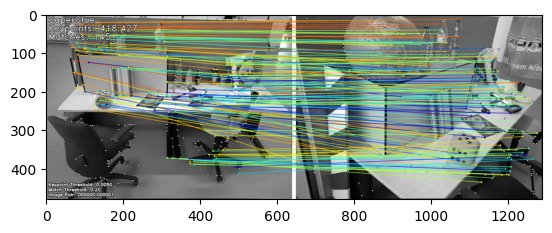

In [2]:
SuperGlue = Matching(config).eval().to(device)

img_1 = cv2.imread('./assets/freiburg_sequence/1341847980.722988.png', cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread('./assets/freiburg_sequence/1341847989.802890.png', cv2.IMREAD_GRAYSCALE)
img_3 = cv2.imread('./assets/freiburg_sequence/1341847995.870641.png', cv2.IMREAD_GRAYSCALE)
tensor_1 = frame2tensor(img_1, device)
tensor_2 = frame2tensor(img_2, device)

pred = SuperGlue({'image0': tensor_1, 'image1': tensor_2})
kpts0 = pred['keypoints0'][0].cpu().numpy()
kpts1 = pred['keypoints1'][0].cpu().numpy()
matches = pred['matches0'][0].cpu().numpy()
confidence = pred['matching_scores0'][0].detach().cpu().numpy()

imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, SuperGlue)

Then try using the wrapper and changing configs.

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


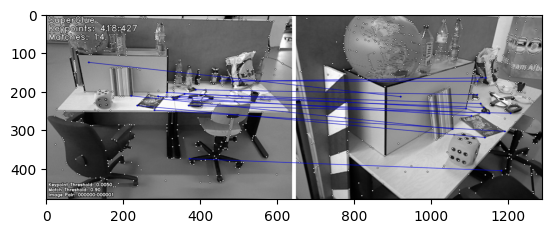

In [3]:
from models.SuperGlueWrapper import SuperGlueWrapper

wrapper = SuperGlueWrapper(match_threshold=0.9, device=device)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_1, img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)

One way is to use `forward_full` that goes through the whole pipeline to find keypoints and matching results on a pair of images. For a sequence of images, this creates computational redundancy.

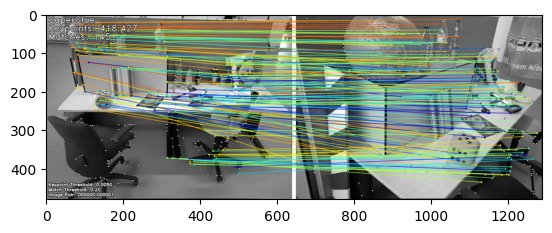

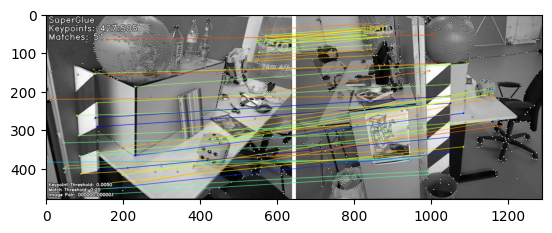

In [4]:
wrapper.set_config(match_threshold=0.2)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_1, img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)
kpts0, matches, confidence, kpts1 = wrapper.forward_full(img_2, img_3)
imshow_inline(img_2, img_3, kpts0, matches, confidence, kpts1, wrapper.model)

Another way is to use `forward_append` with `get_keypoints`. Here for the middle image, keypoints and descriptors are only calculated once.

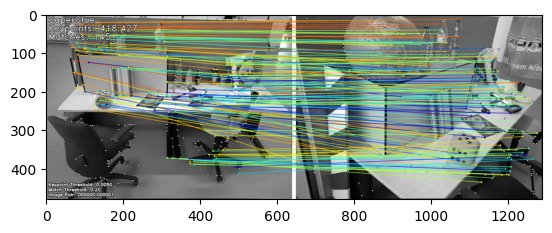

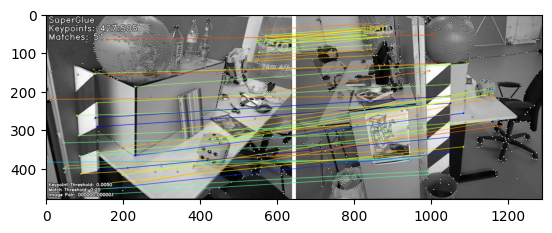

In [5]:
wrapper.get_init_keypoints(img_1)
kpts0, matches, confidence, kpts1 = wrapper.forward_append(img_2)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)
kpts0, matches, confidence, kpts1 = wrapper.forward_append(img_3)
imshow_inline(img_2, img_3, kpts0, matches, confidence, kpts1, wrapper.model)

First extract keypoints and descriptors, then call matcher

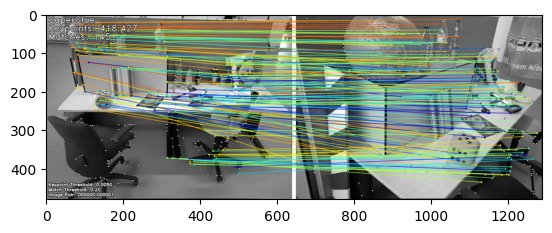

In [6]:
kpts0, scores0, des0, frame_tensor0 = wrapper.get_keypoints(img_1)
kpts1, scores1, des1, frame_tensor1 = wrapper.get_keypoints(img_2)

kpts0, matches, confidence, kpts1 = wrapper.match(
    kpts0,
    scores0,
    des0,
    frame_tensor0,
    kpts1,
    scores1,
    des1,
    frame_tensor1,
)
imshow_inline(img_1, img_2, kpts0, matches, confidence, kpts1, wrapper.model)

In [7]:
print(kpts0.shape)
print(kpts0)

(418, 2)
[[ 79.   8.]
 [ 92.   8.]
 [179.   8.]
 [192.   8.]
 [197.   8.]
 [202.   8.]
 [244.   9.]
 [251.  10.]
 [256.  10.]
 [261.  10.]
 [354.  12.]
 [419.  14.]
 [444.  14.]
 [463.  14.]
 [483.  14.]
 [509.  14.]
 [502.  15.]
 [519.  15.]
 [576.  16.]
 [ 71.  17.]
 [583.  18.]
 [591.  18.]
 [134.  21.]
 [ 82.  22.]
 [ 92.  22.]
 [302.  23.]
 [ 63.  25.]
 [290.  25.]
 [372.  26.]
 [625.  26.]
 [ 80.  29.]
 [168.  29.]
 [305.  31.]
 [ 58.  33.]
 [193.  35.]
 [123.  37.]
 [173.  38.]
 [157.  43.]
 [ 53.  44.]
 [182.  44.]
 [297.  44.]
 [197.  48.]
 [283.  48.]
 [618.  49.]
 [ 54.  50.]
 [ 92.  52.]
 [206.  52.]
 [177.  53.]
 [165.  54.]
 [ 55.  55.]
 [135.  55.]
 [580.  55.]
 [309.  56.]
 [111.  57.]
 [184.  59.]
 [195.  59.]
 [579.  60.]
 [ 80.  61.]
 [621.  61.]
 [155.  65.]
 [284.  66.]
 [629.  70.]
 [308.  71.]
 [ 59.  72.]
 [101.  73.]
 [180.  74.]
 [ 81.  75.]
 [168.  76.]
 [197.  81.]
 [129.  83.]
 [ 85.  85.]
 [137.  85.]
 [ 67.  86.]
 [158.  86.]
 [185.  86.]
 [579.  86.]
 [1

In [8]:
print(scores0.shape)
print(scores0)

(1, 418)
[[0.00524863 0.00905834 0.10783334 0.01402845 0.04206705 0.00847628
  0.10768542 0.02928536 0.00585675 0.18768656 0.17895792 0.30275247
  0.00636921 0.23198715 0.30908647 0.01364297 0.18792607 0.030381
  0.19565095 0.01862493 0.00810864 0.26552424 0.23823267 0.02345132
  0.17391182 0.36399636 0.03458919 0.45596108 0.00571908 0.22848696
  0.00635386 0.25062922 0.11341838 0.00690229 0.23431562 0.11703084
  0.02251963 0.1917032  0.0094978  0.08194853 0.02905251 0.25320062
  0.20295238 0.14955738 0.02334103 0.35259175 0.22467683 0.4420588
  0.28105658 0.00619061 0.0777503  0.00890035 0.22830535 0.5574614
  0.33195227 0.44698292 0.139502   0.18046157 0.06784806 0.20604546
  0.3027914  0.1557014  0.17375334 0.13451679 0.14070831 0.16309357
  0.03035192 0.02503789 0.03479002 0.354201   0.06753315 0.02289912
  0.29541647 0.55478156 0.01326391 0.141646   0.15742917 0.13615878
  0.15750848 0.36472312 0.01366203 0.02638824 0.08792551 0.00682302
  0.00658898 0.49738342 0.03284563 0.024043

In [9]:
print(des0.shape)
print(des0)

(256, 418)
[[-0.11262333 -0.05482312 -0.02223778 ... -0.03327782 -0.05913676
  -0.0431226 ]
 [-0.10042956 -0.08502775  0.04659383 ...  0.08355739  0.12316018
   0.14006071]
 [-0.15462886 -0.14675157 -0.01945991 ...  0.06964212  0.03587566
  -0.00671644]
 ...
 [-0.00716177 -0.00336793  0.00690363 ...  0.01997855 -0.01134239
  -0.06236968]
 [-0.03642822 -0.07384897  0.02432831 ...  0.03110629  0.0242589
   0.00911807]
 [ 0.0572834   0.05075588 -0.00805332 ... -0.02121585 -0.04559392
  -0.02256556]]


In [10]:
print(frame_tensor0.shape)
print(frame_tensor0)

(1, 1, 480, 640)
[[[[0.62352943 0.6313726  0.627451   ... 0.7411765  0.7529412
    0.75686276]
   [0.6392157  0.63529414 0.63529414 ... 0.76862746 0.78039217
    0.78039217]
   [0.6313726  0.6313726  0.63529414 ... 0.76862746 0.78431374
    0.85882354]
   ...
   [0.4392157  0.43529412 0.4392157  ... 0.4745098  0.47058824
    0.4745098 ]
   [0.4509804  0.44705883 0.44313726 ... 0.4745098  0.4745098
    0.4745098 ]
   [0.4392157  0.43529412 0.4392157  ... 0.47843137 0.4745098
    0.47058824]]]]


In [11]:
print(matches.shape)
print(matches)

(418,)
[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  10  17  -1   9  -1  -1  -1  -1  39  -1  22  -1  29  58
  48  53  -1  -1  45  -1  55  -1  -1 102  -1  71 103  -1  88  -1  67 105
  97  98  -1 139  -1  -1  89  -1  91  -1 176  -1 182 156  -1  -1 214 172
 221 183  -1  -1 174  -1 131 128 200 203  -1  -1 225 198  -1  -1  -1  -1
  -1  -1  -1 218  -1  -1 113  -1 237  -1  -1  -1 211  -1  -1 141 168  -1
  -1  -1  -1 153  -1  -1  -1 272 257 152  -1  -1 164 169 162  -1  -1 242
  -1 250  -1  -1 256  -1 239  -1  -1  -1  -1  -1  -1 188  -1  -1  -1 311
 321 190  -1  -1 207  -1  -1  -1  -1  -1 210 212  -1 216  -1  -1  -1 204
  -1  -1  -1  -1  -1 227  -1 222  -1 251  -1  -1  -1  -1  -1 233  -1  -1
 223  -1 350 231  -1 228 380  -1  -1 236  -1 254 247 345 230  -1  -1  -1
 238 370 314  -1 363  -1 226 283 296 229 273  -1 270 262 240 305 334 326
 323  -1 291 280 253  -1  -1 288 258  -1 243  -1 278 351 286  -1 373 279
 306 259  -1 276  -1 249  -1 385 298 274  -1